# Fitting A Linear Model to Data with Errors in X and Y

**Warning:** This notebook came from a workshop on Bayesian methods. We include it here for reference in case you are interested, but the topic is a highly advanced one, especially toward the end. This is *not* somethinge we expect the participants in the Flying Circus to digest! But it illustrates fitting data, Monte-Carlo methods, Bayesian priors, and the surprising fact that linear regression is *not* as simple as you might think

Probably one of the most common things we do is fit one observable against another (say $x$ vs $y$). This is typically done with the method of least-squares. If you assume the uncertainty in your data is Gaussian and only in the $y$ values, then you can get a best-fit by minimizing $\chi^2$:
$$ \chi ^2 = \sum \frac{\left(y_i - m(x_i)\right)^2}{\sigma^2_i} $$
where your data points $(x_i,y_i)$ are fit with a model $m(x_i)$ and have errors $\sigma_i$. The problem is, what if there are errors in both $x$ *and* $y$?

To explore this, we'll create some fake data (just so we know exactly what's going on and what the truth is) and plot it out. You can change the number of points, errors, and slopes/intercet if you like and re-run the notebook to see what happens.

Text(0, 0.5, 'Y')

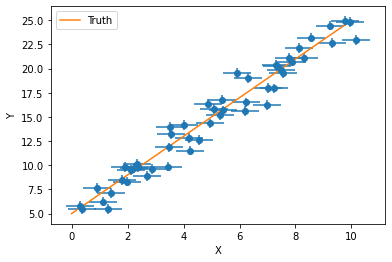

In [2]:
import numpy as np
import matplotlib.pyplot as plt

N = 50              # Number of data points
sig_x = 0.5         # error in 'x'
sig_y = 0.5         # error in 'y'
a_true = 5.0        # True intercept
b_true = 2.0        # True slope

x_true = np.random.uniform(0,10,size=N)
y_true = a_true + x_true*b_true

# Now add some random (Gaussian) noise to the true values
x_obs = x_true + np.random.normal(0, sig_x, size=N)
y_obs = y_true + np.random.normal(0, sig_y, size=N)

# Plot it up 
fig,ax = plt.subplots(1)
ax.errorbar(x_obs, y_obs, xerr=sig_x, yerr=sig_y, fmt='o')
xx = np.array([0,10])
yy = a_true + xx*b_true
ax.plot(xx, yy, '-', label="Truth")
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')

Looks reasonable, I hope. We want to find the best-fit line to the data. It should be close to the orange line (the truth), but not equal, since we introduced noise. First, we could fit this with ``scipy.optimize.curve_fit`` as in a [previous notebook](https://colab.research.google.com/drive/11RbE0YWAn14FvnNAQ8WBLYO1wSzL2P9K?usp=sharing). It needs an error (``sigma``), but that's usually the error in $y$. How do we incorporate the error in $x$?. Well, one way to think about it is we are minimizing the residuals (numerator of $\chi^2$), call them $\Delta_i$:
$$ \Delta_i = y_i - (a + b x_i)$$
so the total uncertainty is:
$$ \sigma^2_i = \left(\frac{\partial \Delta_i}{\partial x_i}\right)^2 \sigma^2_{x,i} + \left(\frac{\partial \Delta_i}{\partial y_i}\right)^2 \sigma^2_{y,i} = b^2\sigma^2_{x,i} + \sigma^2_{y,i}$$
So we just need to add the error in y to the error in x, scaled by the slope, in quadrature. But... we don't know the slope until we solve the problem! Normally, you would make an initial guess, compute the errors, fit for the line, update the slope, compute the errors again, fit for a better slope, and repeat this process until the slope converges to a fixed value. To save on time, let's just cheat and use the true slope to compute the errors.

[4.84492562 2.00281208]
[[ 0.12254818 -0.01865812]
 [-0.01865812  0.00369768]]


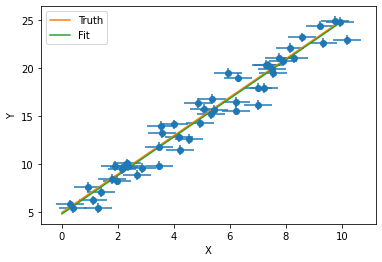

In [3]:
from scipy.optimize import curve_fit
def mod(x, a, b):
    return a + x*b
sig_y = np.ones(N)*sig_y   # curve_fit needs arrays of errors
sig_x = np.ones(N)*sig_x
sigma_total = np.sqrt(sig_y**2 + b_true**2*sig_x**2)
pars,cov = curve_fit(mod, x_obs, y_obs, [0, 1], sigma=sigma_total)
print(pars)
print(cov)
ax.plot(xx, xx*pars[1]+pars[0], label="Fit")
ax.legend()
fig


The green line (our fit to the data) should be pretty close to the orange line. You could re-run the notebook a few times to see the result change again and again (since the data would be random each time). This is a method called Monte Carlo (MC) and you can use it to make sure your method is working. Let's do that. We'll re-create the observed data many times, keeping the true values the same (you can choose how long you want to wait). Each time, we compute the slope and intercept, then save these values in a couple of lists. Finally, make histograms of the values we got and compare to the truth.

Text(0.5, 0, 'intercept')

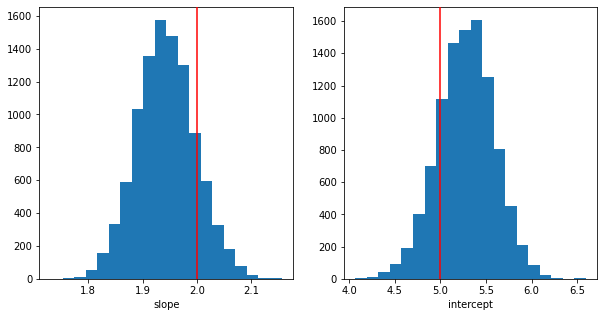

In [4]:
slopes = []
intercepts = []
for i in range(10000):
    x_obs = x_true + np.random.normal(0, sig_x, size=N)
    y_obs = y_true + np.random.normal(0, sig_y, size=N)
    sig_total = y_obs*0 + np.sqrt(sig_x**2*b_true**2 + sig_y**2)
    pars,cov = curve_fit(mod, x_obs, y_obs, [0,1], sigma=sig_total)
    slopes.append(pars[1])
    intercepts.append(pars[0])
fig,axes = plt.subplots(1,2, figsize=(10,5))
axes[0].hist(slopes, bins=20)
axes[0].axvline(b_true, color='red', zorder=10)
axes[0].set_xlabel('slope')
axes[1].hist(intercepts, bins=20)
axes[1].axvline(a_true, color='red', zorder=10)
axes[1].set_xlabel('intercept')

You should see a couple of histograms and red lines that represent the true values. Depending on what you chose for your uncertainties, the red lines may not line up with the peaks of the distributions. In fact, the larger you make the $x$ errors, the more they won't agree. Now, this isn't just due to a random draw and noisy data. This is happening *on average* over a large number of trials. The conclusion:  least-squares is a biased estimator of a linear model when errors are present in the $x$ values (also called the predictor variable).

The reason is a subtle one which we'll get to. But you might be thinking that it has something to do with keeping the errors $\sigma_i$ fixed, when they really should vary as the slope varies. We can test that, but least-squares won't allow this. Instead, we can use the MCMC techniques we [saw earlier](https://colab.research.google.com/drive/15EsEFbbLiU2NFaNrfiCTlF_i65ShDlmS?usp=sharing). First up, let's do the problem with ``emcee``.

In [5]:
from scipy.stats import norm
def lnprior(p):
    a,b = p
    # Return log(p) = 0, uniform (or uninformative)
    return 0

def lnlike(p, x, y, dx, dy):
    a,b = p
    model = mod(x, a, b)
    # errors updated at each iteration
    sig_tot = np.sqrt(dx**2*b**2 + dy**2)
    return sum(norm.logpdf(y, loc=model, scale=sig_tot))

def lnprob(p, x, y, dx, dy):
    a,b = p
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -inf
    return lp + lnlike(p, x, y, dx, dy)

Nwalker,Ndim = 10,2
ptrue = np.array([a_true,b_true])
# add a random vector 0.1 times the true vector to the true vector
p0 = [ptrue + 0.1*np.random.randn(Ndim)*ptrue for i in range(Nwalker)]

Note that the priors are completely uninformative (uniform over all values). The likelihood is computed in the usual way with the normal distribution and we comptue the total error based on the current slope, which is updated at each iteration, so the errors will change as the walkers make their way through parameters space. You should think about what this might mean as the slope becomes small or large. Let's run a bunch of walkers and see what we get.

In [6]:
import emcee
sampler = emcee.EnsembleSampler(Nwalker, Ndim, lnprob, args=(x_obs, y_obs, sig_x, sig_y))
pos,prob,state = sampler.run_mcmc(p0, 500)

Now plot out the samples to see how long it takes to get a convergence.

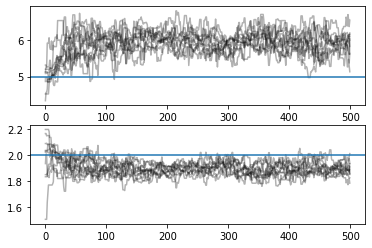

In [7]:
fig,ax = plt.subplots(2,1)
res = [ax[i].plot(sampler.chain[:,:,i].T, '-', color='k', alpha=0.3) for i in range(2)]
res = [ax[i].axhline(ptrue[i]) for i in range(2)]

Looks like 100 iterations should do it. Let's reset and run for longer and print out the results.

In [8]:
sampler.reset()
pos,prob,state = sampler.run_mcmc(pos, 1000)
print(np.mean(sampler.flatchain, axis=0))
print(np.std(sampler.flatchain, axis=0))

[5.93444795 1.89883461]
[0.2750144  0.05036413]


Okay, slope and intercept are "close". But do we have the same problem we did before? If we run this a bunch of times, will the result still be biased? Let's check. I'm only going to run this for 100 iterations, just to get an idea. MCMC samplers take much longer to run than simple least-squares. We'll print out the index as we go so you can judge if it will take too long on your computer and if you might want to reduce the number of loops.

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

Text(0.5, 0, 'intercept')

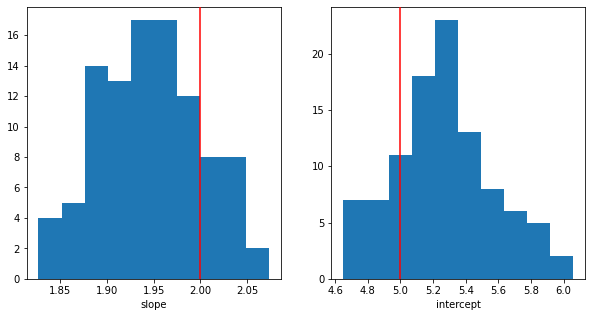

In [9]:
slopes = []
intercepts = []
for i in range(100):
    x_obs = x_true + np.random.normal(0, sig_x, size=N)
    y_obs = y_true + np.random.normal(0, sig_y, size=N)
    sampler = emcee.EnsembleSampler(Nwalker, Ndim, lnprob, args=(x_obs, y_obs, sig_x, sig_y))
    pos,prob,state = sampler.run_mcmc(pos, 100)
    sampler.reset()
    pos,prob,state = sampler.run_mcmc(pos, 500)
    mns = np.mean(sampler.flatchain, axis=0)
    slopes.append(mns[1])
    intercepts.append(mns[0])
    print(i, end=' ')
    
fig,axes = plt.subplots(1,2, figsize=(10,5))
axes[0].hist(slopes, bins=10)
axes[0].axvline(b_true, color='red', zorder=10)
axes[0].set_xlabel('slope')
axes[1].hist(intercepts, bins=10)
axes[1].axvline(a_true, color='red', zorder=10)
axes[1].set_xlabel('intercept')

Hmmmm. Looks like the problem is still there. So what's the reason for this? Well, it has to do with the way that we incorporated the $\sigma_x$, obviously. This was done by what's called *marginalizing*. Let's look a bit more closely at what it means to have observed our data.

## The (Bayesian) Math
We know (since we made the fake data ourselves) that both $x$ and $y$ had noise added to them that was Gaussian (normally distributed). So, using $N$ to represent normal distributions, the likelihoods for our observed $x$ and $y$ values are:
$$ P\left(x_i\left| x_i^T,\sigma_{x,i}\right.\right) = N(x_i-x_i^T, \sigma_{x,i})$$
$$ P\left(y_i\left| y_i^T,\sigma_{y,i}\right.\right) = N(y_i-y_i^T, \sigma_{y,i})$$
In other words, the $x$ data is drawn from a normal distribution whose mean (center) is the true value $x^T_i$, and whose width is the uncertainty $\sigma_{x,i}$. Likewise for $y_i$, except the true value of $y_i$ can be written in terms of our model, so:
$$ P\left(y_i\left| y_i^T,\sigma_{y,i}\right.\right) = N(y_i - a - b x_i^T, \sigma_{y,i})$$
and together, these give us a joint log-likelihood for the entire data set $\vec{D}$:

$$\log P\left(\vec{D}\left|x_i^T,a,b\right.\right) = \sum_i \log N\left(x_i-x_i^T, \sigma_{x,i}\right)
  + \sum_i \log N\left(y_i - a - b x_i^T, \sigma_{y,i}\right)$$
If we're just interested in parameter estimation, we can use Bayes' rule and the fact that the denominator (evidence) is just a constant $C$:
$$\log P\left(x_i^T,a,b\left|\vec{D}\right.\right) = \log P\left(\vec{D}\left|x_i^T,a,b\right.\right) + \log P\left(x_i^T,a,b\right) + C$$
But we've got all these $x_i^T$ values floating around. In real life, we don't know what these are, so we are forced to consider them as unknown (nuisance) parameters. It would be really nice if we could get rid of them. Well, turns out you can do that. If you assume the priors for $x_i^T$ are seperable, you can integrate the posterior over all possible values of $x_i^T$:
$$\log P\left(a,b\left|\vec{D}\right.\right) = P(a,b)\sum_i \int \log P\left(\vec{D}\left|x_i^T,a,b\right.\right)
P\left(x_i^T\right) dx_i^T + C$$
If we assume: 1) uniform priors $P(x_i^T) \propto 1$, $P(a,b)\propto 1$, that all $x_i^T$ are independent, and integrate from $-\infty$ to $+\infty$, we get the nice result (I've skipped all the gory math):
$$ P\left(a,b\left|\vec{D}\right.\right) = \sum_i \log N\left(y_i - a - b x_i, \sqrt{\sigma^2_{y,i}+b^2\sigma^2_{x,i}}\right) = - \frac{1}{2}\chi^2$$
and the right-hand side is only in terms of observables and our two parameters of interest. We have marginalized over all the $x_i^T$, so they no longer appear in the likelihood (and in fact have been replaced with the observed $x_i$). And this is just least-squares with the same error we used above.

The *real* problem is we assumed uniform priors on $x_i^T$ and integrated from $-\infty$ to $+\infty$. That is not anywhere close to how we generated $x^T_i$. In the very first cell, I drew ``x_true`` from a uniform distribution between 0 and 10. In reality, no true value of a measurement you make will ever have equal probability over all values from $-\infty$ to $+\infty$. This is why you have to be careful with your priors!

Okay, so we have to fix $P(x_i^T)$. Unfortunately, just about anything you do to make the prior realistic will make it non-integrable. You'll have to use numerical approximations (the `erf` function, numerical integration, etc). So to do this "right" we'll have to keep all those $x^T_i$ as free parameters instead of marginalizing. This is going to be a problem for ``emcee``, since the number of walkers generally has to increase geometrically with the number of parameters. Luckily, STAN doesn't have this limitation. 

## Doing it right with STAN

STAN uses the Hamiltonian Monte Carlos sampler, which has some very interesting analogies to statistical mechanics. For our purposes, it's enough to know that it handles large parameter spaces efficiently. If you want to better understnad how it works, there's an [exellent talk](https://youtu.be/pHsuIaPbNbY) by one of the authors, Michael Betancourt. So we'll try things out with ``pytstan`` (see [previous notebook on using STAN](https://colab.research.google.com/drive/1JIfi4ejY8hcg1l7ozS3kWQix4dLJPcSD?usp=sharing)). As annoying as STAN is to debug, writing the model is in some ways simpler than with packages like emcee, especially when they get complicated.

In [10]:
import pystan
model_str = '''
data {
   int <lower=1> N;   // number of points
   vector[N] x;       // observed x
   vector[N] y;       // observed y
   vector[N] dx;      // error in x
   vector[N] dy;      // error in y
}

parameters {
   real <lower=-10, upper=10> a;        // intercept
   real <lower=-10, upper=10> b;        // slope
   vector<lower=0, upper=10>[N] xtrue;  // true values of x
}

model {
   x ~ normal(xtrue, dx);
   y ~ normal(a + b*xtrue, dy);
}'''
sampler2 = pystan.StanModel(model_code=model_str, verbose=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1cf73ee150596a961eccc1ae272d2b5b NOW.


Note that by putting limits (0,10) on ``xtrue``, I've specified a uniform prior, exactly as the true values were drawn. The other parameters also have uniform priors associated with them. Now we prepare the data and run a test sample, and check to see if we have convergence (``rhat`` close to 1.0).

In [11]:
idata = dict(N=len(x_obs), x=x_obs, y=y_obs, dx=sig_x, dy=sig_y)
output = sampler2.sampling(data=idata, chains=4, iter=1000, warmup=500)
print(output)

Inference for Stan model: anon_model_1cf73ee150596a961eccc1ae272d2b5b.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a           4.47    0.01   0.31   3.83   4.27   4.48   4.69   5.06    645   1.01
b           2.07  2.0e-3   0.05   1.97   2.03   2.06    2.1   2.17    629    1.0
xtrue[1]    6.01  3.8e-3   0.22   5.58   5.86   6.01   6.16   6.45   3485    1.0
xtrue[2]    6.69  4.6e-3   0.22   6.24   6.53   6.69   6.83   7.13   2323    1.0
xtrue[3]    1.95  4.9e-3   0.23   1.47    1.8   1.95   2.11    2.4   2276    1.0
xtrue[4]    4.42  4.6e-3   0.23   3.98   4.26   4.43   4.57   4.88   2447    1.0
xtrue[5]    7.52  4.2e-3   0.23   7.07   7.37   7.52   7.68   7.97   2963    1.0
xtrue[6]    3.69  4.3e-3   0.23   3.22   3.54   3.69   3.84   4.15   2925    1.0
xtrue[7]     1.1  5.7e-3   0.23   0.64   0.95    1.1   1.25   1.56   1647    1.0
xtr

Note that we now have N+2 parameters being reported. I kept the number of iterations lower than I would normally and the values of ``Rhat`` and standard errors in the parameters look reasonable. If not, increase ``iter``. But even though STAN lets you have large numbers of parameters, the more you have, the slower the sampler will be. We'll do the same thing we did above and re-fit random data sets many times. This will take a while...  grab a coffee or tea. Catch up on facebook. But for this final example, we want enough samples to be confident we've "fixed" the problem.

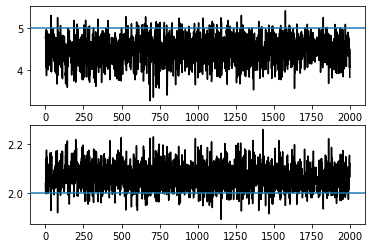

In [12]:
fig,ax = plt.subplots(2,1)
chains = output.extract(['a','b'], permuted=True)
ax[0].plot(chains['a'], '-', color='k')
ax[0].axhline(a_true, zorder=10)
ax[1].plot(chains['b'], '-', color='k')
ax[1].axhline(b_true, zorder=10)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

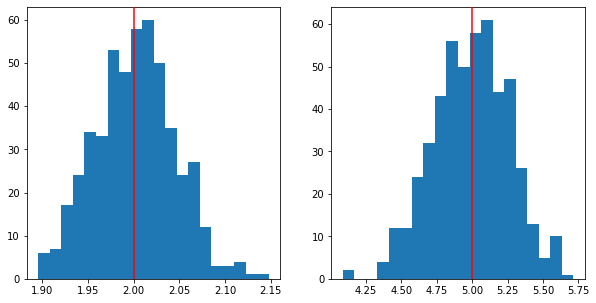

In [13]:
slopes = []
intercepts = []
for i in range(500):
    x_obs = x_true + np.random.normal(0, sig_x, size=N)
    y_obs = y_true + np.random.normal(0, sig_y, size=N)
    idata = dict(N=len(x_obs), x=x_obs, y=y_obs, dx=sig_x, dy=sig_y)
    output = sampler2.sampling(data=idata, chains=4, iter=1000, warmup=500)
    samples = output.extract(permuted=True)
    slopes.append(np.mean(samples['b']))
    intercepts.append(np.mean(samples['a']))
    print(i, end=' ')
    
fig,axes = plt.subplots(1,2, figsize=(10,5))
axes[0].hist(slopes, bins=20)
axes[0].axvline(b_true, color='red', zorder=10)
axes[1].hist(intercepts, bins=20)
axes[1].axvline(a_true, color='red', zorder=10)

What you should now see is that the histograms and true values line up. Maybe not perfectly, but certainly better than they did with least-squares and running ``emcee`` with marginalized $x_i^T$. The takeaway from all this is that biases can creep in not just from data, but also from the numerical methods you use to analyze that data. It's always good to validate your methods with fake data/simulations.


## Hiearchical Modeling
Suppose we don't have a a good idea of what the appropriate prior should be. In the example above, I knew that a uniform prior from 0 to 10 was correct, but maybe in real life, it's not so obvious.

This is where we can get creative and make the priors of our $x$ values functions of other, unknown parameters. Let's make our data over again, but this time, I'll draw my $x$ values from an exponential rather than a uniform distribution. Everything else we'll keep the same.

(array([18.,  7., 15.,  5.,  0.,  1.,  1.,  0.,  2.,  1.]),
 array([ 0.64082836,  6.04303623, 11.44524409, 16.84745195, 22.24965981,
        27.65186767, 33.05407553, 38.45628339, 43.85849126, 49.26069912,
        54.66290698]),
 <a list of 10 Patch objects>)

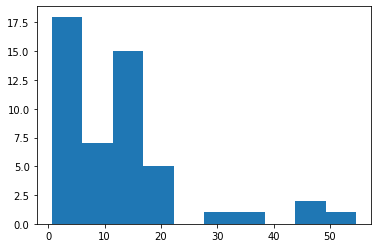

In [14]:
tau = 10
x_true = np.random.exponential(tau,size=N)
y_true = a_true + x_true*b_true

# Once again, add some random (Gaussian) noise to the true values
x_obs = x_true + np.random.normal(0, sig_x, size=N)
y_obs = y_true + np.random.normal(0, sig_y, size=N)

# See what the distribution of x's look like
plt.hist(x_obs, bins=10)

And how let's suppose that you have a vague idea that your $x$ values are drawn from an exponential distribution, but you don't know what scale it has. You could try to determine it from the histogram above, but because we've convolved the true distribution with random noise, it's been broadened and we'd overestimate it. So let's leave $\tau$ as a free parameter. Because it's function is to inform the prior on $x$, we're now in the realm of hierarchical Bayesian inference and $\tau$ is a hyper-parameter. Welcome to the party! But STAN makes it easy to handle:

In [15]:
model_str = '''
data {
   int <lower=1> N;   // number of points
   vector[N] x;       // observed x
   vector[N] y;       // observed y
   vector[N] dx;      // error in x
   vector[N] dy;      // error in y
}

parameters {
   real <lower=-10, upper=10> a;        // intercept
   real <lower=-10, upper=10> b;        // slope
   vector<lower=0>[N] xtrue;            // true values of x
   real <lower=0, upper=100> beta;       // scale hyper-parameter
}

model {
   // Note beta = 1/tau
   xtrue ~ exponential(beta);
   x ~ normal(xtrue, dx);
   y ~ normal(a + b*xtrue, dy);
}'''
sampler2 = pystan.StanModel(model_code=model_str, verbose=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fad3632a05a5ca19bdc08508485a5ee5 NOW.


In [16]:
idata = dict(N=len(x_obs), x=x_obs, y=y_obs, dx=sig_x, dy=sig_y)
output = sampler2.sampling(data=idata, chains=4, iter=5000, warmup=500)
print(output)

Inference for Stan model: anon_model_fad3632a05a5ca19bdc08508485a5ee5.
4 chains, each with iter=5000; warmup=500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=18000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a            5.2  2.8e-3   0.23   4.75   5.05    5.2   5.35   5.63   6411    1.0
b           2.01  1.4e-4   0.01   1.98    2.0   2.01   2.02   2.04   9984    1.0
xtrue[1]    4.65  1.6e-3   0.24   4.18    4.5   4.65   4.81   5.12  20793    1.0
xtrue[2]    1.93  1.7e-3   0.24   1.46   1.77   1.93    2.1    2.4  20015    1.0
xtrue[3]   11.17  1.4e-3   0.23  10.72  11.02  11.17  11.33  11.62  26499    1.0
xtrue[4]   17.01  1.3e-3   0.23  16.55  16.85  17.01  17.17  17.47  34160    1.0
xtrue[5]     5.1  1.7e-3   0.23   4.63   4.94    5.1   5.25   5.56  19948    1.0
xtrue[6]    0.67  2.1e-3   0.24    0.2   0.51   0.67   0.83   1.13  12225    1.0
xtrue[7]   18.27  1.3e-3   0.24  17.81  18.11  18.27  18.43  18.73  31951    1.0
x

And we'll just finish off with the usual plots:

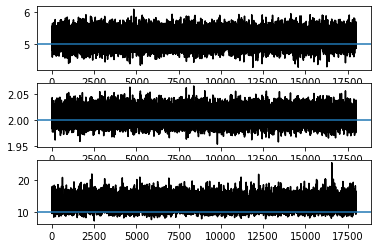

In [17]:
fig,ax = plt.subplots(3,1)
chains = output.extract(['a','b','beta'], permuted=True)
ax[0].plot(chains['a'], '-', color='k')
ax[0].axhline(a_true, zorder=10)
ax[1].plot(chains['b'], '-', color='k')
ax[1].axhline(b_true, zorder=10)
ax[2].plot(1/chains['beta'], '-', color='k')
ax[2].axhline(tau, zorder=10)

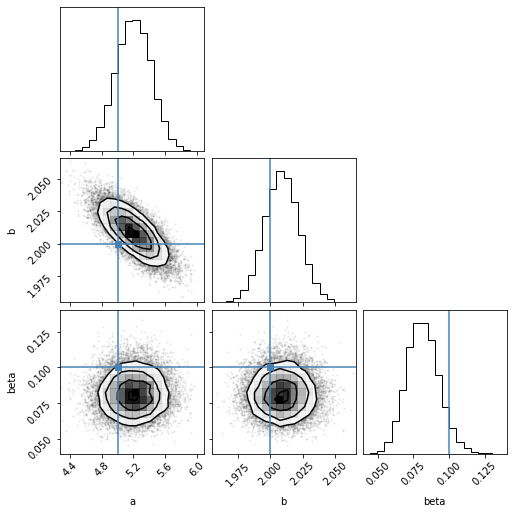

In [18]:
from corner import corner
achains = np.array([chains['a'],chains['b'],chains['beta']]).T
fig = corner(achains, labels=['a','b','beta'], truths=[a_true,b_true,1/tau])

So that's how one can build informative priors based on other unknown parameters. Of course, you can build even deeper hierarchies, perhaps putting a prior on $\beta$. Eventually, you have to stop, of course, and make some assumptions, usually when you reach the parameter where you have no prior knowledge at all. Even at that point, one should impose a uniform or Jeffrey's prior to keep things finite.

If you want to see an example of a more (much more) sophisticated hierarchical modeling for the simple case of linear regression, have a look at [this paper by Brandon Kelly](https://ui.adsabs.harvard.edu/abs/2007ApJ...665.1489K/abstract). Be warned: it's quite a read, but I learned a lot from it. The model is implemented in the code [LINMIX](https://github.com/jmeyers314/linmix).